In [ ]:
# Import the dataset

from google.colab import files
files.upload()

Saving amazon_alexa.tsv to amazon_alexa (1).tsv


{'amazon_alexa.tsv': b'\xef\xbb\xbfrating\tdate\tvariation\tverified_reviews\tfeedback\r\n5\t31-Jul-18\tCharcoal Fabric \tLove my Echo!\t1\r\n5\t31-Jul-18\tCharcoal Fabric \tLoved it!\t1\r\n4\t31-Jul-18\tWalnut Finish \t"Sometimes while playing a game, you can answer a question correctly but Alexa says you got it wrong and answers the same as you.  I like being able to turn lights on and off while away from home."\t1\r\n5\t31-Jul-18\tCharcoal Fabric \t"I have had a lot of fun with this thing. My 4 yr old learns about dinosaurs, i control the lights and play games like categories. Has nice sound when playing music as well."\t1\r\n5\t31-Jul-18\tCharcoal Fabric \tMusic\t1\r\n5\t31-Jul-18\tHeather Gray Fabric \t"I received the echo as a gift. I needed another Bluetooth or something to play music easily accessible, and found this smart speaker. Can\xe2\x80\x99t wait to see what else it can do."\t1\r\n3\t31-Jul-18\tSandstone Fabric \t"Without having a cellphone, I cannot use many of her feat

In [ ]:
# Import Glove model

!wget https://www.dropbox.com/s/dx3lup5lo0w6gn8/glove.6B.100d.txt   #?dl=0

--2019-07-09 11:14:42--  https://www.dropbox.com/s/dx3lup5lo0w6gn8/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/dx3lup5lo0w6gn8/glove.6B.100d.txt [following]
--2019-07-09 11:14:43--  https://www.dropbox.com/s/raw/dx3lup5lo0w6gn8/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd135ff28f23533b2cf07be1945.dl.dropboxusercontent.com/cd/0/inline/AkUKgQKpYd73MvgqgYHYXw06AmgZi3CxOBGAB8zrGldwT5zoC2zBhoQtlu_XRbkvua3Y29AzPV5Bzt85ydbbPlxs-XTV15tKgLDAWKloxTNKmw/file# [following]
--2019-07-09 11:14:44--  https://ucd135ff28f23533b2cf07be1945.dl.dropboxusercontent.com/cd/0/inline/AkUKgQKpYd73MvgqgYHYXw06AmgZi3CxOBGAB8zrGldwT5zoC2zBhoQtlu_XRbkvua3Y29AzPV5Bzt85ydbbPlxs-XTV15tKgLDAWKloxTNKmw/file
Re

In [ ]:
# Importing important packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import sequence

Using TensorFlow backend.


In [ ]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 8000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [ ]:
df = pd.read_csv('amazon_alexa.tsv', sep='\t')                                  # Reading the dataset

In [ ]:
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [ ]:
df.feedback.value_counts()

1    2893
0     257
Name: feedback, dtype: int64

In [ ]:
X = df['verified_reviews']
y = df['feedback']

N = X.shape[0]

In [ ]:
### Import Spacy and model

import spacy
from spacy.util import minibatch, compounding
nlp = spacy.load('en_core_web_sm')

## Text Cleaning

In [ ]:
# Removing stopwords and lemmatization

corpus = []

for i in range(0, N):
  doc = nlp(X[i])
  review = [token.lemma_ for token in doc if not token.is_stop]
  corpus.append(" ".join(review))
      

In [ ]:
# Tokenization

t=Tokenizer(num_words=MAX_NB_WORDS)
t.fit_on_texts(corpus)
sequences = t.texts_to_sequences(corpus)

In [ ]:
word_index = t.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 3132


In [ ]:
# Sentence padding

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
# Converting the labels to categorical

labels = []

for idx in y:
  labels.append(idx)
  
labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

Shape of Data Tensor: (3150, 1000)
Shape of Label Tensor: (3150, 2)


In [ ]:
# Train Validation split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [ ]:
# Loading Glove 6B 100d model

embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [ ]:
# Text embedding using Glove

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))        # Return an array of random numbers with the size provided
for word, i in word_index.items():                                               # For every word in the word index, find the embedding vector
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector                                   # Save the embedding vector in the embedding matrix

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

W0709 11:16:55.572564 140468321732480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



## Convolutional Neural Network
Building the CNN model for text classification after word embedding

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)                             # The first layer consisting of embedding input
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)                    # The CNN layers
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)                                  # The output layer

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)   # Model Checkpointer callback

W0709 11:17:05.132071 140468321732480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 11:17:05.148142 140468321732480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0709 11:17:05.172263 140468321732480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0709 11:17:05.173799 140468321732480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0709 11:17:05.558000 140468321732480 depre

Simplified convolutional neural network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         313300    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 

In [ ]:
# Tensorboard log

import tensorflow as tf
log_dir = './tf-log/text_classification_cnn'
tb_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

### Tensorboard Visualization

In [ ]:
# Tensorboard

!wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
# start tensorboard on localhost 6006

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(log_dir)
)

In [ ]:
# start ngrok and asking ngrok to forward to port to 6006 where tensorboard is running 
get_ipython().system_raw('./ngrok http 6006 &')

In [ ]:
# get url generated from ngrok

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://9923cb01.ngrok.io


## Train the CNN model

In [ ]:
# Fitting the model on train data and evaluation in Validation data

history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp, tb_cb])

W0709 11:18:47.711063 140468321732480 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2520 samples, validate on 630 samples
Epoch 1/15
2520/2520 [==============================] - 51s 20ms/step - loss: 0.3615 - acc: 0.9167 - val_loss: 0.3798 - val_acc: 0.9238

Epoch 00001: val_acc improved from -inf to 0.92381, saving model to model_cnn.hdf5
Epoch 2/15
2520/2520 [==============================] - 50s 20ms/step - loss: 0.3184 - acc: 0.9103 - val_loss: 0.2844 - val_acc: 0.9254

Epoch 00002: val_acc improved from 0.92381 to 0.92540, saving model to model_cnn.hdf5
Epoch 3/15
2520/2520 [==============================] - 51s 20ms/step - loss: 1.0532 - acc: 0.9187 - val_loss: 1.2280 - val_acc: 0.9238

Epoch 00003: val_acc did not improve from 0.92540
Epoch 4/15
2520/2520 [==============================] - 51s 20ms/step - loss: 1.3368 - acc: 0.9171 - val_loss: 1.2280 - val_acc: 0.9238

Epoch 00004: val_acc did not improve from 0.92540
Epoch 5/15
2520/2520 [==============================] - 50s 20ms/step - loss: 1.3368 - acc: 0.9171 - val_loss: 1.2280 - val_acc: 0.9238


In [ ]:
# Predictions from the trained model

y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)
y_pred.shape

(630,)

In [ ]:
y_val2 = np.argmax(y_val, axis=1)
y_val2.shape

(630,)

In [ ]:
# Confusion Matrix from the predictions of CNN model

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val2,y_pred))

[[  0  48]
 [  0 582]]


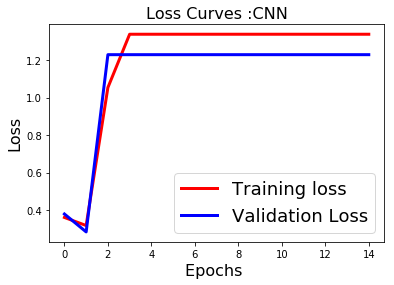

In [ ]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

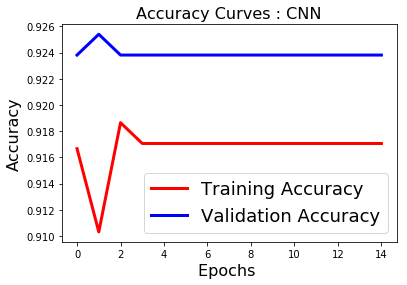

In [ ]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

### Saving CNN Model

In [ ]:
model.save("model_CNN.h5")
print("Saved model to disk")

Saved model to disk


## Recurrent Neural Network

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

In [ ]:
from keras.layers import LSTM

In [ ]:
l_lstm_1 = LSTM(256)(embedded_sequences)
preds = Dense(2, activation='softmax')(l_lstm_1)

model2 = Model(sequence_input, preds)

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         313300    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 679,382
Trainable params: 679,382
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Checkpointer
cp=ModelCheckpoint('model_rnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)   # Model Checkpointer callback

# Tensorboard log

log_dir = './tf-log/text_classification_rnn'
tb_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
# start tensorboard on localhost 6006

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(log_dir)
)

In [ ]:
# start ngrok and asking ngrok to forward to port to 6006 where tensorboard is running 
get_ipython().system_raw('./ngrok http 6006 &')

In [ ]:
# get url generated from ngrok

! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://9923cb01.ngrok.io


## Training the RNN model

In [ ]:
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=10, batch_size=256,callbacks=[cp, tb_cb])

Train on 2520 samples, validate on 630 samples
Epoch 1/10
2520/2520 [==============================] - 197s 78ms/step - loss: 0.3167 - acc: 0.9139 - val_loss: 0.2507 - val_acc: 0.9238

Epoch 00001: val_acc improved from -inf to 0.92381, saving model to model_rnn.hdf5
Epoch 2/10
2520/2520 [==============================] - 192s 76ms/step - loss: 0.2415 - acc: 0.9171 - val_loss: 0.2342 - val_acc: 0.9238

Epoch 00002: val_acc did not improve from 0.92381
Epoch 3/10
2520/2520 [==============================] - 191s 76ms/step - loss: 0.2085 - acc: 0.9202 - val_loss: 0.2076 - val_acc: 0.9254

Epoch 00003: val_acc improved from 0.92381 to 0.92540, saving model to model_rnn.hdf5
Epoch 4/10
2520/2520 [==============================] - 189s 75ms/step - loss: 0.1802 - acc: 0.9345 - val_loss: 0.1913 - val_acc: 0.9333

Epoch 00004: val_acc improved from 0.92540 to 0.93333, saving model to model_rnn.hdf5
Epoch 5/10
2520/2520 [==============================] - 194s 77ms/step - loss: 0.1628 - acc: 0.9

In [ ]:
y_pred2 = model2.predict(x_val)
y_pred2 = np.argmax(y_pred2, axis=1)
y_pred2.shape

(630,)

In [ ]:
y_val2 = np.argmax(y_val, axis=1)
y_val2.shape

(630,)

In [ ]:
print(confusion_matrix(y_val2,y_pred2))

[[ 20  28]
 [  9 573]]


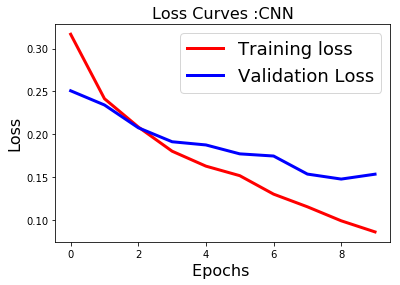

In [ ]:
fig1 = plt.figure()
plt.plot(history2.history['loss'],'r',linewidth=3.0)
plt.plot(history2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

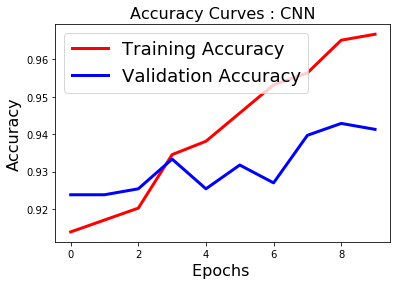

In [ ]:
fig2=plt.figure()
plt.plot(history2.history['acc'],'r',linewidth=3.0)
plt.plot(history2.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

### Saving the RNN model

In [ ]:
model2.save("model_RNN.h5")
print("Saved model to disk")

Saved model to disk
